In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm


%matplotlib inline

In [48]:
data = pd.read_csv('data_to_model.csv')
data.head()

,Accident_Index,Age_Band_of_Driver,include_pedestrian,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Day_of_Week,1st_Road_Class,1st_Road_Number,...,Number_Casualties_Group,Junction_Group,Pedestrian_Control,Pedestrian_PhisFac,Active_Light,Weather,Road_Surf_Cond,Special_Conds,Carriageway_Haz,Commute_hours
0,2016010000005,5.0,0,519310.0,188730.0,-0.279323,51.584754,3,3,4006,...,1,1,1,1,0,1,1,1,1,0
1,2016010000006,7.0,0,551920.0,174560.0,0.184928,51.449595,3,3,207,...,1,3,1,1,1,1,1,1,1,0
2,2016010000008,5.0,0,505930.0,183850.0,-0.473837,51.543563,3,3,4020,...,1,2,1,1,1,1,1,1,1,0
3,2016010000016,8.0,0,527770.0,168930.0,-0.164442,51.404958,3,3,217,...,1,3,1,1,1,1,1,1,1,1
4,2016010000019,6.0,0,530840.0,167100.0,-0.121004,51.387813,3,3,23,...,1,3,1,2,1,1,1,1,1,1


In [49]:
data['Class'].value_counts()

0    64867
1    12836
Name: Class, dtype: int64

In [50]:
data = data.set_index('Accident_Index')
data.columns

Index(['Age_Band_of_Driver', 'include_pedestrian', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Day_of_Week',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       '2nd_Road_Class', '2nd_Road_Number', 'Urban_or_Rural_Area',
       'LSOA_of_Accident_Location', 'Class', 'weekdays', 'Casualty_IMD_Group',
       'Driver_IMD_Group', 'Vehicle_Age_Group', 'Number_Vehicles_Group',
       'Number_Casualties_Group', 'Junction_Group', 'Pedestrian_Control',
       'Pedestrian_PhisFac', 'Active_Light', 'Weather', 'Road_Surf_Cond',
       'Special_Conds', 'Carriageway_Haz', 'Commute_hours'],
      dtype='object')

In [51]:
correlation = data.corr('spearman')


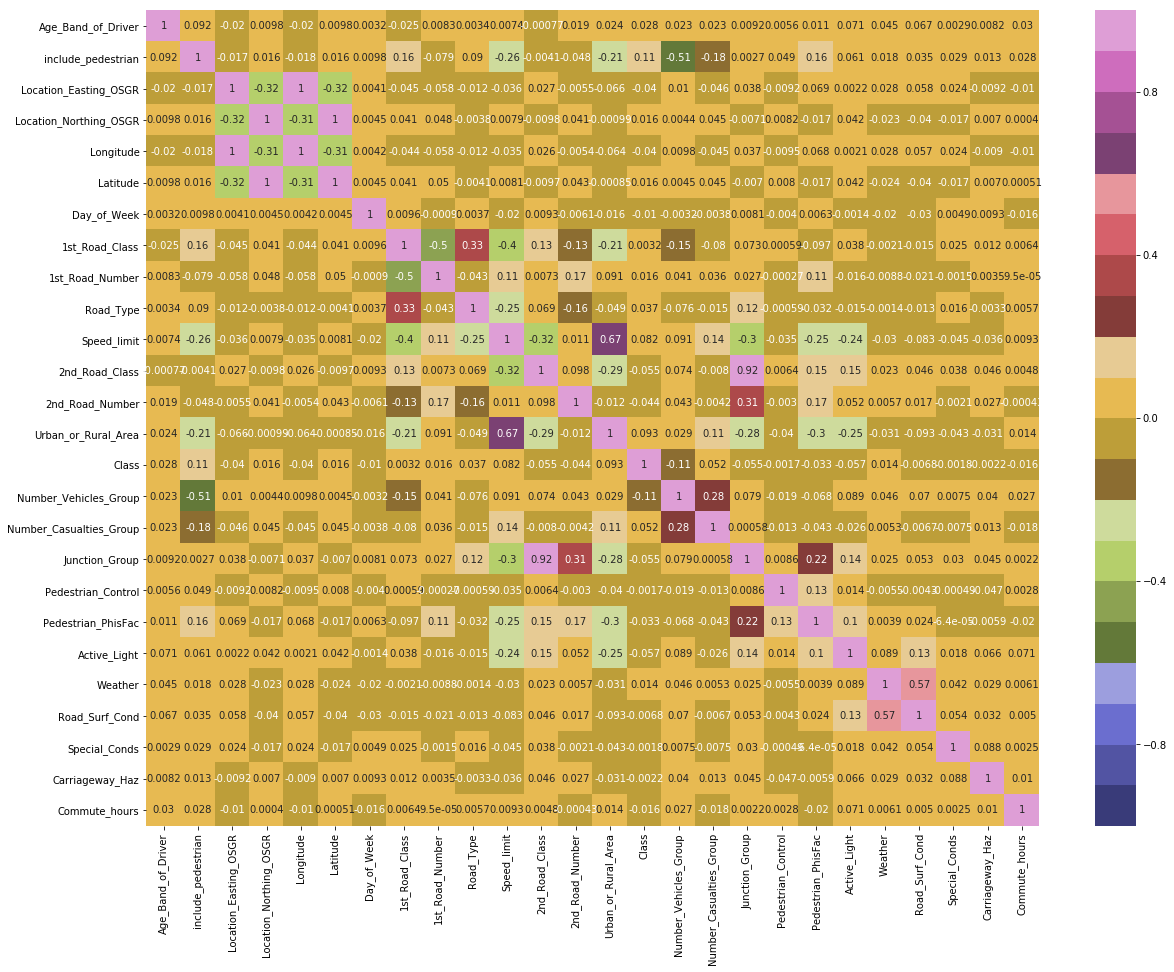

In [52]:
plt.figure(figsize=(20,15))
sns.heatmap(correlation, annot = True, vmin = -1, vmax= 1,cmap = 'tab20b')
plt.show()

In [53]:
#remove correlated variables
data = data.drop(['Location_Easting_OSGR','Location_Northing_OSGR', '2nd_Road_Class',
                  'Latitude', 'Longitude'], axis = 1)

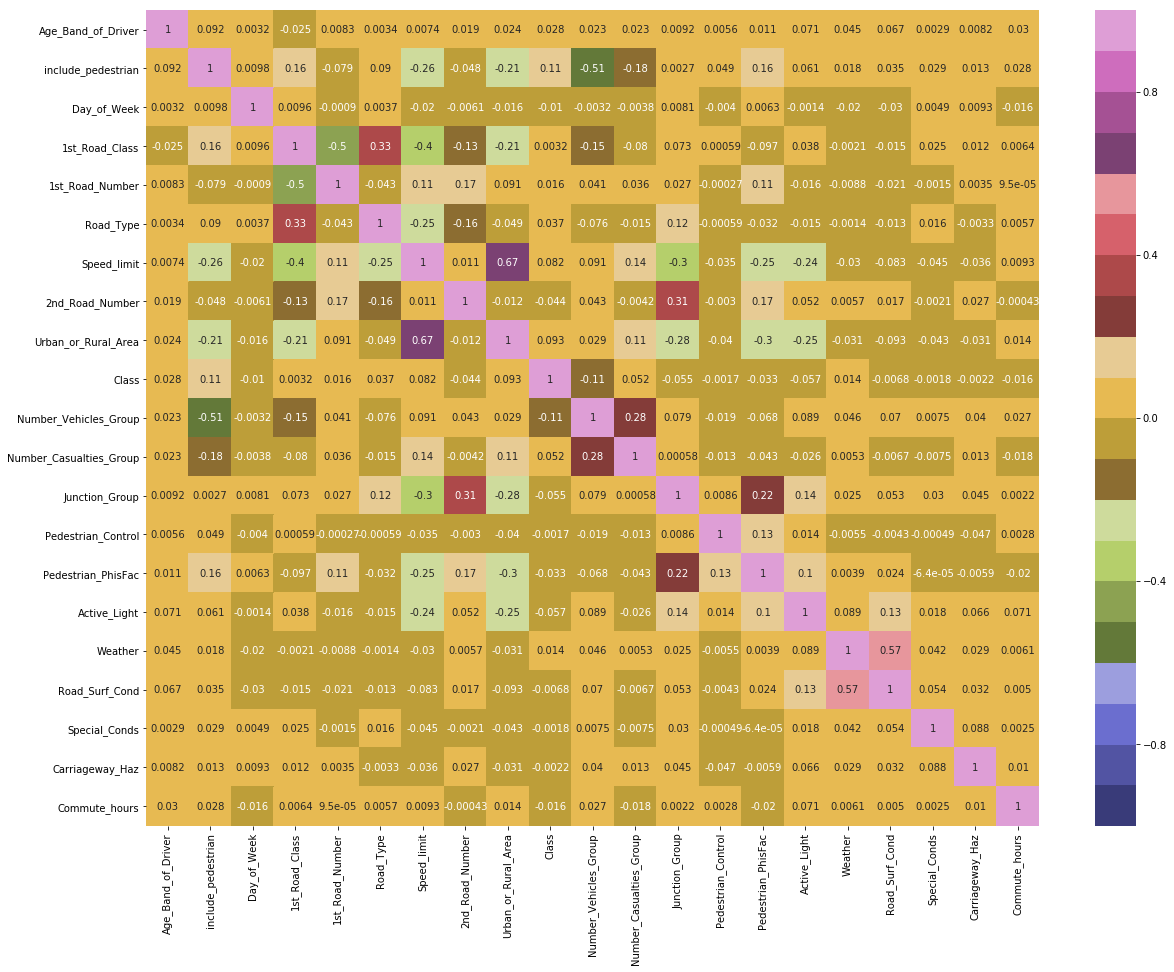

In [54]:
correlation = data.corr('spearman')
plt.figure(figsize=(20,15))
sns.heatmap(correlation, annot = True, vmin = -1, vmax= 1,cmap = 'tab20b')
plt.show()

In [55]:
#information value metrics
#good_acc == 0, bad_acc == 1
#predictive power 0.02 to 0.1 weak, 0.1 to 0.3 medium, 0.3 to 0.5 strong and >0.5 suspicious or too good predictor

# Calculation of IV  metrics
def IV_calc(data,var):
    if data[var].dtypes == "object":
        dataf = data.groupby([var])['Class'].agg(['count','sum'])
        dataf.columns = ["Total","bad"]    
        dataf["good"] = dataf["Total"] - dataf["bad"]
        dataf["bad_acc"] = dataf["bad"]/dataf["bad"].sum()
        dataf["good_acc"] = dataf["good"]/dataf["good"].sum()
        dataf["I_V"] = (dataf["good_acc"] - dataf["bad_acc"]) * np.log(dataf["good_acc"]/dataf["bad_acc"])
        return dataf
    else:
        data['bin_var'] = pd.qcut(data[var].rank(method='first'),10)
        dataf = data.groupby(['bin_var'])['Class'].agg(['count','sum'])
        dataf.columns = ["Total","bad"]    
        dataf["good"] = dataf["Total"] - dataf["bad"]
        dataf["bad_acc"] = dataf["bad"]/dataf["bad"].sum()
        dataf["good_acc"] = dataf["good"]/dataf["good"].sum()
        dataf["I_V"] = (dataf["good_acc"] - dataf["bad_acc"]) * np.log(dataf["good_acc"]/dataf["bad_acc"])
        return dataf

In [56]:
print ("\n\nInformation Value by descending order\n")

discrete_columns = ['Age_Band_of_Driver', 'include_pedestrian',   'Day_of_Week',
                    '1st_Road_Class', 'Road_Type', 'Speed_limit',
                     'Urban_or_Rural_Area',
                     'weekdays', 
                    'Casualty_IMD_Group', 'Driver_IMD_Group', 'Vehicle_Age_Group',
                    'Number_Vehicles_Group', 'Number_Casualties_Group', 'Junction_Group',
                    'Pedestrian_Control', 'Pedestrian_PhisFac', 'Active_Light', 'Weather',
                    'Road_Surf_Cond', 'Special_Conds', 'Carriageway_Haz', 'Commute_hours']

continuous_columns = []#['Longitude', 'Latitude', '1st_Road_Number', '2nd_Road_Number']

total_columns = discrete_columns + continuous_columns

# List of IV values
Iv_list = []
for col in total_columns:
    assigned_data =  IV_calc(data = data,var = col)
    iv_val = round(assigned_data["I_V"].sum(),3)
    dt_type = data[col].dtypes
    Iv_list.append((iv_val,col,dt_type))

Iv_list = sorted(Iv_list,reverse = True)

for i in range(len(Iv_list)):
    print (Iv_list[i][0],",",Iv_list[i][1],",type =",Iv_list[i][2])



Information Value by descending order

0.174 , include_pedestrian ,type = int64
0.144 , Number_Vehicles_Group ,type = int64
0.103 , Speed_limit ,type = float64
0.098 , Urban_or_Rural_Area ,type = int64
0.084 , Active_Light ,type = int64
0.081 , Special_Conds ,type = int64
0.078 , Number_Casualties_Group ,type = int64
0.078 , Carriageway_Haz ,type = int64
0.077 , Road_Type ,type = float64
0.075 , Pedestrian_Control ,type = int64
0.073 , Weather ,type = int64
0.071 , Junction_Group ,type = int64
0.069 , Road_Surf_Cond ,type = int64
0.069 , Pedestrian_PhisFac ,type = int64
0.063 , Commute_hours ,type = int64
0.036 , 1st_Road_Class ,type = int64
0.031 , Age_Band_of_Driver ,type = float64
0.029 , Vehicle_Age_Group ,type = object
0.013 , Day_of_Week ,type = int64
0.006 , weekdays ,type = object
0.004 , Driver_IMD_Group ,type = object
0.004 , Casualty_IMD_Group ,type = object


In [57]:
#considering all vars


discrete_columns = ['Age_Band_of_Driver', 'include_pedestrian',   'Day_of_Week',
                    '1st_Road_Class', 'Road_Type', 'Speed_limit',
                     'Urban_or_Rural_Area',
                     'weekdays', 
                    'Casualty_IMD_Group', 'Driver_IMD_Group', 'Vehicle_Age_Group',
                    'Number_Vehicles_Group', 'Number_Casualties_Group', 'Junction_Group',
                    'Pedestrian_Control', 'Pedestrian_PhisFac', 'Active_Light', 'Weather',
                    'Road_Surf_Cond', 'Special_Conds', 'Carriageway_Haz', 'Commute_hours']

continuous_columns = []#['Longitude', 'Latitude']#, '1st_Road_Number', '2nd_Road_Number']







#get_dummies for cat_vars

dummy_Casualty_IMD_Group = pd.get_dummies(data['Casualty_IMD_Group'], prefix='Casualty_IMD_Group')
dummy_Age_Band_of_Driver = pd.get_dummies(data['Age_Band_of_Driver'], prefix='Age_Band_of_Driver')
dummy_Driver_IMD_Group = pd.get_dummies(data['Driver_IMD_Group'], prefix='Driver_IMD_Group')
dummy_include_pedestrian = pd.get_dummies(data['include_pedestrian'], prefix='include_pedestrian')
dummy_Day_of_Week = pd.get_dummies(data['Day_of_Week'], prefix='Day_of_Week')

dummy_1st_Road_Class = pd.get_dummies(data['1st_Road_Class'], prefix='1st_Road_Class')
dummy_Road_Type = pd.get_dummies(data['Road_Type'], prefix='Road_Type')
dummy_Speed_limit = pd.get_dummies(data['Speed_limit'], prefix='Speed_limit')
dummy_Urban_or_Rural_Area = pd.get_dummies(data['Urban_or_Rural_Area'], prefix='Urban_or_Rural_Area')
dummy_weekdays = pd.get_dummies(data['weekdays'], prefix='weekdays')

dummy_Vehicle_Age_Group = pd.get_dummies(data['Vehicle_Age_Group'], prefix='Vehicle_Age_Group')
dummy_Number_Vehicles_Group = pd.get_dummies(data['Number_Vehicles_Group'], prefix='Number_Vehicles_Group')
dummy_Number_Casualties_Group = pd.get_dummies(data['Number_Casualties_Group'], prefix='Number_Casualties_Group')
dummy_Junction_Group = pd.get_dummies(data['Junction_Group'], prefix='Junction_Group')
dummy_Pedestrian_Control = pd.get_dummies(data['Pedestrian_Control'], prefix='Pedestrian_Control')
dummy_Pedestrian_PhisFac = pd.get_dummies(data['Pedestrian_PhisFac'], prefix='Pedestrian_PhisFac')

dummy_Active_Light = pd.get_dummies(data['Active_Light'], prefix='Active_Light')
dummy_Weather = pd.get_dummies(data['Weather'], prefix='Weather')
dummy_Road_Surf_Cond = pd.get_dummies(data['Road_Surf_Cond'], prefix='Road_Surf_Cond')
dummy_Special_Conds = pd.get_dummies(data['Special_Conds'], prefix='Special_Conds')
dummy_Carriageway_Haz = pd.get_dummies(data['Carriageway_Haz'], prefix='Carriageway_Haz')
dummy_Commute_hours = pd.get_dummies(data['Commute_hours'], prefix='Commute_hours')





continuous = data[continuous_columns]
data_new = pd.concat([dummy_Casualty_IMD_Group,dummy_Age_Band_of_Driver,dummy_Driver_IMD_Group,
                    dummy_include_pedestrian,  dummy_Day_of_Week,
                    dummy_1st_Road_Class, dummy_Road_Type, dummy_Speed_limit, dummy_Urban_or_Rural_Area,
                      dummy_weekdays, dummy_Vehicle_Age_Group,
                    dummy_Number_Vehicles_Group, dummy_Number_Casualties_Group, dummy_Junction_Group,
                    dummy_Pedestrian_Control, dummy_Pedestrian_PhisFac, dummy_Active_Light, dummy_Weather,
                    dummy_Road_Surf_Cond, dummy_Special_Conds, dummy_Carriageway_Haz,
                      dummy_Commute_hours,continuous,data['Class']],axis=1)

x_train,x_test,y_train,y_test = train_test_split(data_new.drop(['Class'],axis=1),data_new['Class'],
                                                 train_size = 0.7,test_size = 0.3, 
                                                 random_state=42)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


In [58]:
data_new.columns

Index(['Casualty_IMD_Group_high', 'Casualty_IMD_Group_low',
       'Casualty_IMD_Group_med_high', 'Casualty_IMD_Group_med_low',
       'Age_Band_of_Driver_2.0', 'Age_Band_of_Driver_3.0',
       'Age_Band_of_Driver_4.0', 'Age_Band_of_Driver_5.0',
       'Age_Band_of_Driver_6.0', 'Age_Band_of_Driver_7.0',
       'Age_Band_of_Driver_8.0', 'Age_Band_of_Driver_9.0',
       'Age_Band_of_Driver_10.0', 'Age_Band_of_Driver_11.0',
       'Driver_IMD_Group_high', 'Driver_IMD_Group_low',
       'Driver_IMD_Group_med_high', 'Driver_IMD_Group_med_low',
       'include_pedestrian_0', 'include_pedestrian_1', 'Day_of_Week_1',
       'Day_of_Week_2', 'Day_of_Week_3', 'Day_of_Week_4', 'Day_of_Week_5',
       'Day_of_Week_6', 'Day_of_Week_7', '1st_Road_Class_1',
       '1st_Road_Class_2', '1st_Road_Class_3', '1st_Road_Class_4',
       '1st_Road_Class_5', '1st_Road_Class_6', 'Road_Type_1.0',
       'Road_Type_2.0', 'Road_Type_3.0', 'Road_Type_6.0', 'Road_Type_7.0',
       'Road_Type_9.0', 'Speed_limit_20.0

In [59]:
data.shape[0]

77703

In [60]:
#0.82858 is proportion betwwen bad and good accidents at the beginning , it changed because of removing NaNs
proportion_bad = data[data.Class == 1].shape[0]/data.shape[0]
proportion_good = 1 - proportion_bad
print('proportion of serious before removing nans: ' ,np.round(proportion_bad,4))

proportion of serious before removing nans:  0.1652


In [61]:
data_new_sample = data_new.sample(frac = 0.1, replace=False)
proportion_bad = data_new_sample[data_new_sample.Class == 1].shape[0]/data_new_sample.shape[0]
print('proportion of serious after removing nans: ' ,np.round(proportion_bad,4))

proportion of serious after removing nans:  0.1605


In [62]:
data_new_sample.shape

(7770, 81)

In [63]:
#training with initial sample size in train and test, only 10% of data
data_new_sample_train_bad = data_new[data_new['Class'] == 1].sample(frac = 0.1, replace = False)
data_new_sample_train_good = data_new[data_new['Class'] == 0].sample(frac = 0.1, replace = False)
data_train = pd.concat([data_new_sample_train_bad, data_new_sample_train_good])


#after concatenate I shuffle data taking a sample of frac = 1
data_train = data_train.sample(frac=1).reset_index(drop=True)

In [64]:

data_test = data_new.sample(frac=0.05, replace = False)
x_train = data_train.drop('Class', axis =1)
y_train = data_train['Class']
x_test = data_test.drop('Class', axis =1)
y_test = data_test['Class']

In [65]:
data_new_sample_train_bad.shape

(1284, 81)

In [66]:
#data_new = data_new_sample

In [67]:
#x_train,x_test,y_train,y_test = train_test_split(data_new.drop(['Class'],axis=1),data_new['Class'],train_size = 0.7,test_size = 0.3, random_state=42)
           

rf_fit = RandomForestClassifier(n_estimators=1000,criterion="gini",max_depth=100,min_samples_split=3,
                                min_samples_leaf=2)
rf_fit.fit(x_train,y_train)           

print ("\nRandom Forest - Train Confusion Matrix\n\n",pd.crosstab(y_train,rf_fit.predict(x_train),
                                                                  rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Train accuracy",round(accuracy_score(y_train,rf_fit.predict(x_train)),3))

print ("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab(y_test,rf_fit.predict(x_test),
                                                                   rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Test accuracy",round(accuracy_score(y_test,rf_fit.predict(x_test)),3))


Random Forest - Train Confusion Matrix

 Predicted     0    1
Actual              
0          6487    0
1           987  297

Random Forest - Train accuracy 0.873


Random Forest - Test Confusion Matrix

 Predicted     0   1
Actual             
0          3237   3
1           631  14

Random Forest - Test accuracy 0.837


In [68]:
# Grid Search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV

pipeline = Pipeline([
        ('clf',RandomForestClassifier(criterion='gini'))  ])

parameters = {
        'clf__n_estimators':(1000,2000,3000),
        'clf__max_depth':(50,100),
        'clf__min_samples_split':(2,3),
        'clf__min_samples_leaf':(2,3)  }

grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=5,verbose=1,scoring='accuracy')
grid_search.fit(x_train,y_train)


print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(x_test)

print ("Testing accuracy:",round(accuracy_score(y_test, predictions),4))
print ("\nComplete report of Testing data\n",classification_report(y_test, predictions))

print ("\n\nRandom Forest Grid Search- Test Confusion Matrix\n\n",
       pd.crosstab(y_test, predictions,rownames = ["Actual"],colnames = ["Predicted"]))      



Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 20.9min finished


Best Training score: 0.835
Best parameters set:
	clf__max_depth: 50
	clf__min_samples_leaf: 2
	clf__min_samples_split: 2
	clf__n_estimators: 2000
Testing accuracy: 0.8366

Complete report of Testing data
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      3240
           1       0.78      0.02      0.04       645

   micro avg       0.84      0.84      0.84      3885
   macro avg       0.81      0.51      0.48      3885
weighted avg       0.83      0.84      0.77      3885



Random Forest Grid Search- Test Confusion Matrix

 Predicted     0   1
Actual             
0          3236   4
1           631  14


In [69]:
# Variable Importance chart
import matplotlib.pyplot as plt
rf_fit = RandomForestClassifier(n_estimators=2000,criterion="gini",
                                max_depth=50,min_samples_split=2,min_samples_leaf=2)
rf_fit.fit(x_train,y_train)   

importances = rf_fit.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_fit.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

colnames = list(x_train.columns)
# Print the feature ranking
print("\nFeature ranking:\n")
for f in range(x_train.shape[1]):
    print ("Feature",indices[f],",",colnames[indices[f]],round(importances[indices[f]],4))


Feature ranking:

Feature 53 , Number_Vehicles_Group_1 0.0256
Feature 29 , 1st_Road_Class_3 0.0255
Feature 50 , Vehicle_Age_Group_0-5 0.0241
Feature 51 , Vehicle_Age_Group_10-15 0.0231
Feature 52 , Vehicle_Age_Group_5-10 0.0223
Feature 8 , Age_Band_of_Driver_6.0 0.0219
Feature 57 , Number_Casualties_Group_1 0.0212
Feature 61 , Junction_Group_1 0.0209
Feature 32 , 1st_Road_Class_6 0.02
Feature 63 , Junction_Group_3 0.0196
Feature 3 , Casualty_IMD_Group_med_low 0.0195
Feature 17 , Driver_IMD_Group_med_low 0.0195
Feature 54 , Number_Vehicles_Group_2 0.0188
Feature 25 , Day_of_Week_6 0.0186
Feature 10 , Age_Band_of_Driver_8.0 0.0186
Feature 9 , Age_Band_of_Driver_7.0 0.0185
Feature 73 , Road_Surf_Cond_1 0.018
Feature 72 , Road_Surf_Cond_0 0.0179
Feature 40 , Speed_limit_30.0 0.0176
Feature 79 , Commute_hours_1 0.0176
Feature 78 , Commute_hours_0 0.0174
Feature 15 , Driver_IMD_Group_low 0.0172
Feature 1 , Casualty_IMD_Group_low 0.0168
Feature 23 , Day_of_Week_4 0.0167
Feature 21 , Day_of_W

In [72]:
#x_train,x_test,y_train,y_test = train_test_split(data_new.drop(['Class'],axis=1),data_new['Class']
#                                                 ,train_size = 0.7,test_size = 0.3, random_state=42)
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier


dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=30,min_samples_split=2,min_samples_leaf=2,random_state=42)
dt_fit.fit(x_train,y_train)

print ("\nDecision Tree - Train Confusion Matrix\n\n",pd.crosstab(y_train,dt_fit.predict(x_train),
                                                                  rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Train accuracy:",round(accuracy_score(y_train,dt_fit.predict(x_train)),3))
print ("\nDecision Tree - Train Classification Report\n",classification_report(y_train,dt_fit.predict(x_train)))

print ("\n\nDecision Tree - Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict(x_test),
                                                                   rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Test accuracy:",round(accuracy_score(y_test,dt_fit.predict(x_test)),3))
print ("\nDecision Tree - Test Classification Report\n",classification_report(y_test,dt_fit.predict(x_test)))


Decision Tree - Train Confusion Matrix

 Predicted     0    1
Actual              
0          6382  105
1           453  831

Decision Tree - Train accuracy: 0.928

Decision Tree - Train Classification Report
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      6487
           1       0.89      0.65      0.75      1284

   micro avg       0.93      0.93      0.93      7771
   macro avg       0.91      0.82      0.85      7771
weighted avg       0.93      0.93      0.92      7771



Decision Tree - Test Confusion Matrix

 Predicted     0    1
Actual              
0          2867  373
1           508  137

Decision Tree - Test accuracy: 0.773

Decision Tree - Test Classification Report
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      3240
           1       0.27      0.21      0.24       645

   micro avg       0.77      0.77      0.77      3885
   macro avg       0.56      0.55  

In [75]:
# Tuning class weights to analyze accuracy, precision & recall
dummyarray = np.empty((6,10))
dt_wttune = pd.DataFrame(dummyarray)

dt_wttune.columns = ["zero_wght","one_wght","tr_accuracy","tst_accuracy","prec_zero","prec_one",
                     "prec_ovll","recl_zero","recl_one","recl_ovll"]

zero_clwghts = [0.01,0.1,0.2,0.3,0.4,0.5]

#for each combo of weight-class
for i in range(len(zero_clwghts)):
    #dictionary considering class-weights zero or one
    clwght = {0:zero_clwghts[i],1:1.0-zero_clwghts[i]}
    dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,
                                    min_samples_leaf=2,random_state=42,class_weight = clwght)
    dt_fit.fit(x_train,y_train)
    dt_wttune.loc[i, 'zero_wght'] = clwght[0]       
    dt_wttune.loc[i, 'one_wght'] = clwght[1]     
    dt_wttune.loc[i, 'tr_accuracy'] = round(accuracy_score(y_train,dt_fit.predict(x_train)),3)    
    dt_wttune.loc[i, 'tst_accuracy'] = round(accuracy_score(y_test,dt_fit.predict(x_test)),3)    
        
    clf_sp = classification_report(y_test,dt_fit.predict(x_test)).split()
    dt_wttune.loc[i, 'prec_zero'] = float(clf_sp[5])   
    dt_wttune.loc[i, 'prec_one'] = float(clf_sp[10])   
    dt_wttune.loc[i, 'prec_ovll'] = float(clf_sp[17])   
    
    dt_wttune.loc[i, 'recl_zero'] = float(clf_sp[6])   
    dt_wttune.loc[i, 'recl_one'] = float(clf_sp[11])   
    dt_wttune.loc[i, 'recl_ovll'] = float(clf_sp[18])
    print ("\nClass Weights",clwght,"Train accuracy:",round(accuracy_score(y_train,dt_fit.predict(x_train)),3),
           "Test accuracy:",round(accuracy_score(y_test,dt_fit.predict(x_test)),3))
    print ("Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict(x_test),rownames = ["Actual"],
                                                   colnames = ["Predicted"])) 


Class Weights {0: 0.01, 1: 0.99} Train accuracy: 0.185 Test accuracy: 0.182
Test Confusion Matrix

 Predicted   0     1
Actual             
0          71  3169
1           7   638

Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.518 Test accuracy: 0.502
Test Confusion Matrix

 Predicted     0     1
Actual               
0          1460  1780
1           156   489

Class Weights {0: 0.2, 1: 0.8} Train accuracy: 0.697 Test accuracy: 0.666
Test Confusion Matrix

 Predicted     0    1
Actual              
0          2293  947
1           352  293

Class Weights {0: 0.3, 1: 0.7} Train accuracy: 0.805 Test accuracy: 0.79
Test Confusion Matrix

 Predicted     0    1
Actual              
0          2929  311
1           503  142

Class Weights {0: 0.4, 1: 0.6} Train accuracy: 0.833 Test accuracy: 0.824
Test Confusion Matrix

 Predicted     0    1
Actual              
0          3135  105
1           578   67

Class Weights {0: 0.5, 1: 0.5} Train accuracy: 0.839 Test accuracy: 0.833
Test Conf

In [76]:
# Bagging Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

#define the object
dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,min_samples_leaf=2,random_state=42,
                                class_weight = {0:0.2,1:0.8})

#definr the ensemble method for using with the object
bag_fit = BaggingClassifier(base_estimator= dt_fit,n_estimators=2000,max_samples=0.67,max_features=1.0,
                            bootstrap=True,bootstrap_features=True,n_jobs=-1,random_state=42)

bag_fit.fit(x_train, y_train)

print ("\nBagging - Train Confusion Matrix\n\n",pd.crosstab(y_train,bag_fit.predict(x_train),
                                                            rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nBagging- Train accuracy",round(accuracy_score(y_train,bag_fit.predict(x_train)),3))
print ("\nBagging  - Train Classification Report\n",classification_report(y_train,bag_fit.predict(x_train)))

print ("\n\nBagging - Test Confusion Matrix\n\n",pd.crosstab(y_test,bag_fit.predict(x_test),
                                                             rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nBagging - Test accuracy",round(accuracy_score(y_test,bag_fit.predict(x_test)),3))
print ("\nBagging - Test Classification Report\n",classification_report(y_test,bag_fit.predict(x_test)))



Bagging - Train Confusion Matrix

 Predicted     0     1
Actual               
0          5175  1312
1           609   675

Bagging- Train accuracy 0.753

Bagging  - Train Classification Report
               precision    recall  f1-score   support

           0       0.89      0.80      0.84      6487
           1       0.34      0.53      0.41      1284

   micro avg       0.75      0.75      0.75      7771
   macro avg       0.62      0.66      0.63      7771
weighted avg       0.80      0.75      0.77      7771



Bagging - Test Confusion Matrix

 Predicted     0    1
Actual              
0          2540  700
1           364  281

Bagging - Test accuracy 0.726

Bagging - Test Classification Report
               precision    recall  f1-score   support

           0       0.87      0.78      0.83      3240
           1       0.29      0.44      0.35       645

   micro avg       0.73      0.73      0.73      3885
   macro avg       0.58      0.61      0.59      3885
weighted avg   

In [77]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_fit = RandomForestClassifier(n_estimators=2000,criterion="gini",max_depth=5,min_samples_split=2,bootstrap=True,
                                max_features='auto',random_state=42,min_samples_leaf=2,class_weight = {0:0.2,1:0.8})
rf_fit.fit(x_train,y_train)       

print ("\nRandom Forest - Train Confusion Matrix\n\n",pd.crosstab(y_train,rf_fit.predict(x_train),
                                                                  rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Train accuracy",round(accuracy_score(y_train,rf_fit.predict(x_train)),3))
print ("\nRandom Forest  - Train Classification Report\n",classification_report(y_train,rf_fit.predict(x_train)))

print ("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab(y_test,rf_fit.predict(x_test),
                                                                   rownames = ["Actual"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Test accuracy",round(accuracy_score(y_test,rf_fit.predict(x_test)),3))
print ("\nRandom Forest - Test Classification Report\n",classification_report(y_test,rf_fit.predict(x_test)))


Random Forest - Train Confusion Matrix

 Predicted     0     1
Actual               
0          5275  1212
1           687   597

Random Forest - Train accuracy 0.756

Random Forest  - Train Classification Report
               precision    recall  f1-score   support

           0       0.88      0.81      0.85      6487
           1       0.33      0.46      0.39      1284

   micro avg       0.76      0.76      0.76      7771
   macro avg       0.61      0.64      0.62      7771
weighted avg       0.79      0.76      0.77      7771



Random Forest - Test Confusion Matrix

 Predicted     0    1
Actual              
0          2592  648
1           376  269

Random Forest - Test accuracy 0.736

Random Forest - Test Classification Report
               precision    recall  f1-score   support

           0       0.87      0.80      0.84      3240
           1       0.29      0.42      0.34       645

   micro avg       0.74      0.74      0.74      3885
   macro avg       0.58      0.6

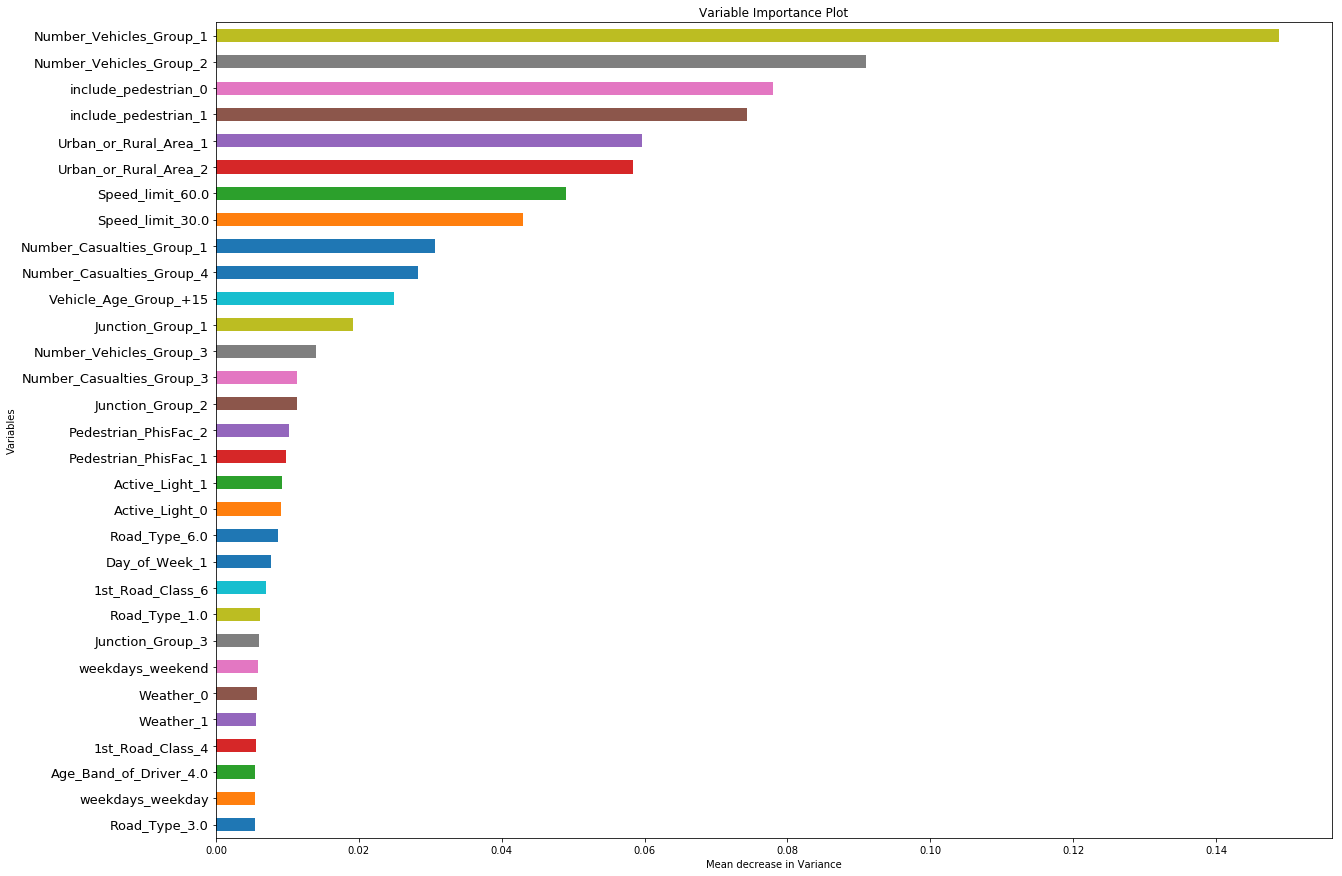

<Figure size 432x288 with 0 Axes>

In [28]:
# Plot of Variable importance by mean decrease in gini
model_ranks = pd.Series(rf_fit.feature_importances_,
                        index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:31].sort_values(ascending=True,inplace=False)
plt.figure(figsize=(20,15))
ax = top_features.plot(kind='barh')
_ = ax.set_title("Variable Importance Plot")
_ = ax.set_xlabel('Mean decrease in Variance')
_ = ax.set_yticklabels(top_features.index, fontsize=13)
plt.show()
plt.savefig('variable_importance_plot_round_one.png')